# Creating new classes

Let us use one of the original Moscow code functions in order to create a new shape of a resonator. Let's say, as a first easy example, we want to add a tail to the previous seen EMResonator_TL2Qbit_worm class

In [524]:
import klayout.db as db
import os
import numpy as np

working_path = os.getcwd()
os.chdir(r'Z:\Fabrication\Designs\Design playground')

from ClassLib import *

os.chdir(working_path)

In [525]:
import ClassLib.Resonators as mres

In [526]:
mres.EMResonator_TL2Qbit_worm??

Init signature:
mres.EMResonator_TL2Qbit_worm(
    Z0,
    start,
    L_coupling,
    L1,
    r,
    L2,
    N,
    trans_in=None,
)
Docstring:     
@brief: base class for simple single-layer or multi-layer elements and objects that are consisting of
        several polygons.
        metal_region polygons will be added to the design
        empty_region polygons will be erased from the background with 
        metal region polygons already added.
Source:        
class EMResonator_TL2Qbit_worm( Complex_Base ):
    def __init__( self, Z0, start, L_coupling, L1, r, L2, N, trans_in=None ):
        self.Z0 = Z0
        self.L_coupling = L_coupling
        self.L1 = L1
        self.r = r
        self.L2 = L2

        self.N = N
        self.primitives_gnd = {}
        super().__init__( start, trans_in )

        self.start = self.connections[0]
        self.end = self.connections[-1]
        self.dr = self.end - self.start
        self.alpha_start = self.angle_connections[0]
        self.alp

Let us draw the basic chip with crosses to delimit its boundaries.

The Resonator classes inherit from the Complex_Base class. Let us try to define a new resonator class. We want the class to have three different lenghts:
1. Length of the coupler to the main CPW
2. Length of the shorted side of the Resonator
3. Length of the open side of the Resonator
    
We also will give it a starting point, and a object with the CPW width and gaps

```python

class Resonator(Complex_Base):
    def __init__( self, Z0, start, L_coupler, L_shorted, L_open):
        self.Z0 = Z0
        self.L_coupler = L_coupler
        self.L_shorted = L_shorted
        self.L_open = L_open
```

Complex_Base classes need to add a function called init_primitives inside the class in order to plot all the different objects we want. In this function, we will add to self.primitives any object we want to plot. Let us start by adding a CPW of length L_shorted starting at some point.

If we want to do this, then we need to inherit from the super() class of Resonator. When this super class in initialized, given a start point, it will run all the primitives designed in the init_primitives function.

In [527]:
class Resonator(Complex_Base):
    def __init__( self, Z0, start, L_coupler, L_shorted, L_open, trans_in = False):
        self.Z0 = Z0
        self.L_coupler = L_coupler
        self.L_shorted = L_shorted
        self.L_open = L_open
        
        self.primitives_gnd = {}
        super().__init__( start, trans_in )
        
        self.start = self.connections[0]
        self.end = self.connections[-1]
        self.dr = self.end - self.start
    def init_primitives( self ):
        self.shorted_cpw = CPW( self.Z0.width, self.Z0.gap, db.DPoint(0,0), db.DPoint(0, - self.L_shorted))
        self.primitives["shorted_cpw"] = self.shorted_cpw
        
        self.connections = [DPoint(0,0), self.shorted_cpw.end]

This will place a very simple $\lambda$/2 CPW resonator of length L_shorted into the design. If you were to use the Resonator class as it is right now, you'd get the following

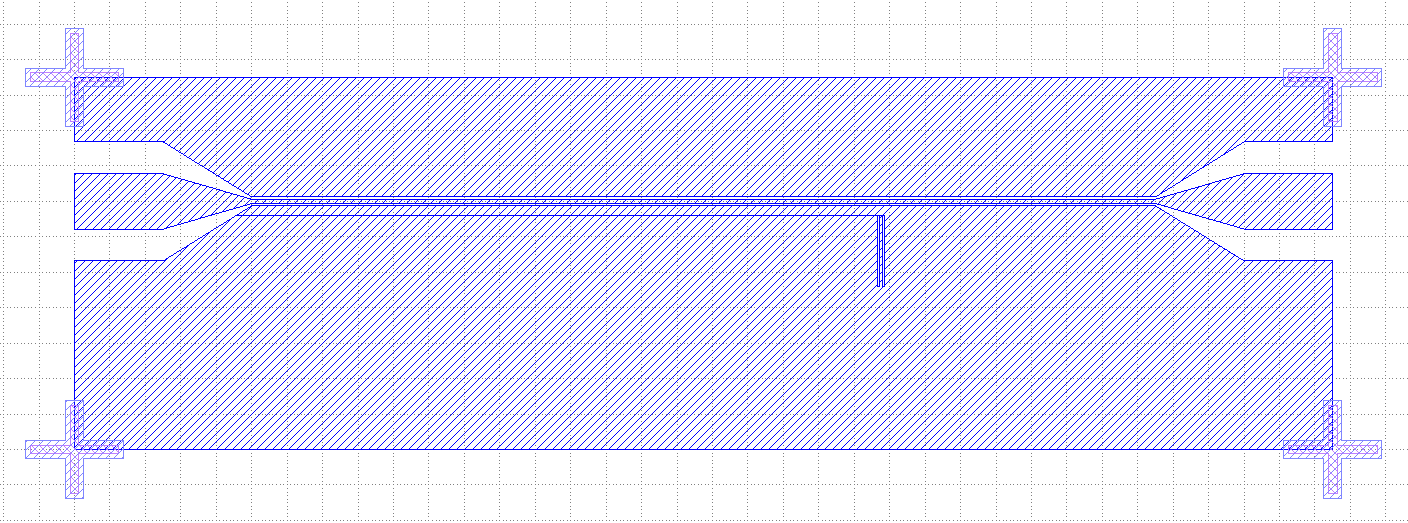

In [528]:
from IPython.display import Image
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/New_Resonator_Class.png')

The resonator is a single CPW line shorted at both ends. Let's try to add a coupler and a worm into it.

In [529]:
class Resonator(Complex_Base):
    def __init__( self, Z0, start, L_coupler, L_shorted, L_open, trans_in = False):
        self.Z0 = Z0
        self.L_coupler = L_coupler
        self.L_shorted = L_shorted
        self.L_open = L_open
        
        self.primitives_gnd = {}
        super().__init__( start, trans_in )
        
        self.start = self.connections[0]
        self.end = self.connections[-1]
        self.dr = self.end - self.start
    def init_primitives( self ):
        self.shorted_cpw = CPW( self.Z0.width, self.Z0.gap, db.DPoint(0,0), db.DPoint(0, - self.L_shorted))
        self.coupler_cpw = CPW( self.Z0.width, self.Z0.gap, db.DPoint(0,0), db.DPoint(self.L_coupler, 0))
        
        self.primitives["shorted_cpw"] = self.shorted_cpw
        self.primitives['coupler_cpw'] = self.coupler_cpw
        
        self.connections = [DPoint(0,0), self.shorted_cpw.end, self.coupler_cpw.end]

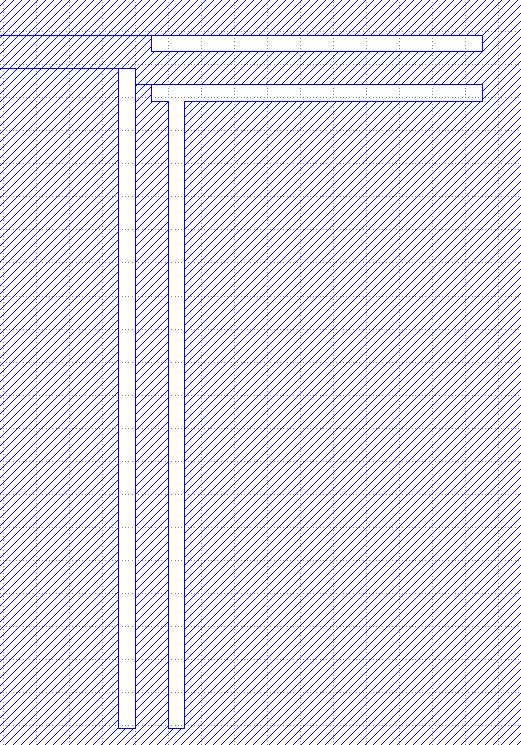

In [530]:
from IPython.display import Image
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/Superposed_Resonators.png')

This class, however, has a big problem. There is no sense of connectivity. Let us remake it, and add a nice connection between the CPWs. We will use a CPW_arc object to give it a more logical continuation.

We will add a arc connection of radius r. CPW_arc can be difficult to use by itself. Recommended way to use right now is to create the two base CPWs and make it start at the one that is horizontal.

In [531]:
class Resonator(Complex_Base):
    def __init__( self, Z0, start, L_coupler, L_shorted, L_open, r, trans_in = False):
        self.Z0 = Z0
        self.L_coupler = L_coupler
        self.L_shorted = L_shorted
        self.L_open = L_open
        self.r = r

        
        self.primitives_gnd = {}
        super().__init__( start, trans_in )
        
        self.start = self.connections[0]
        self.end = self.connections[-1]
        self.dr = self.end - self.start
        
        self.alpha_start = self.angle_connections[0]
        self.alpha_end = self.angle_connections[1]
        
    def init_primitives( self ):
        
        self.shorted_cpw = CPW( self.Z0.width, self.Z0.gap, db.DPoint(0,-self.L_shorted-self.r), db.DPoint(0, -self.r))
        
        self.coupler_cpw = CPW( self.Z0.width, self.Z0.gap, self.shorted_cpw.end + DPoint(self.r, self.r), db.DPoint(self.L_coupler, 0))
        
        self.coupler_to_shorted = CPW_arc( self.Z0, self.coupler_cpw.start, -self.r, np.pi/2)
        
        self.primitives["shorted_cpw"] = self.shorted_cpw
        self.primitives['coupler_cpw'] = self.coupler_cpw
        self.primitives["self.coupler_to_shorted"] = self.coupler_to_shorted
        
        
        
        self.connections = [DPoint(0,0), self.shorted_cpw.end, self.coupler_cpw.end]
        
        self.angle_connections = [0, self.coupler_to_shorted.alpha_end]

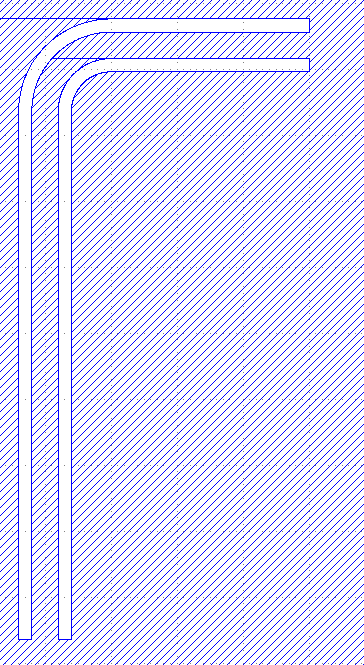

In [532]:
from IPython.display import Image
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/Connected_Resonators.png')

Let's add a worm at the end of the coupler.

In [533]:
class Resonator(Complex_Base):
    def __init__( self, Z0, start, L_coupler, L_shorted, L_open, L_end, r, N, trans_in = False):
        self.Z0 = Z0
        self.L_coupler = L_coupler
        self.L_shorted = L_shorted
        self.L_open = L_open
        self.L_end = L_end
        self.r = r
        self.N = N
        
        self.primitives_gnd = {}
        super().__init__( start, trans_in )
        
        self.start = self.connections[0]
        self.end = self.connections[-1]
        self.dr = self.end - self.start
        
        self.alpha_start = self.angle_connections[0]
        self.alpha_end = self.angle_connections[1]
        
    def init_primitives( self ):
        
        self.shorted_cpw = CPW( self.Z0.width, self.Z0.gap, db.DPoint(0,-self.L_shorted-self.r), db.DPoint(0, -self.r))
        
        self.coupler_cpw = CPW( self.Z0.width, self.Z0.gap, self.shorted_cpw.end + DPoint(self.r, self.r), db.DPoint(self.L_coupler, 0))
        
        self.coupler_to_shorted = CPW_arc( self.Z0, self.coupler_cpw.start, -self.r, np.pi/2)
        
        self.primitives["shorted_cpw"] = self.shorted_cpw
        self.primitives['coupler_cpw'] = self.coupler_cpw
        self.primitives["self.coupler_to_shorted"] = self.coupler_to_shorted
        
        # Create a turning CPW, or 'worm'        
        for i in range(self.N):
            name = "coil" + str(i+1)
            setattr( self, name, Coil_type_1( self.Z0, DPoint( -self.L_open + self.L_coupler, -(i)*(4*self.r) ), self.L_open, self.r, self.L_open ) )
            self.primitives[name] = getattr( self, name )
            
        # draw the "tail"
        self.arc_tail = CPW_arc( self.Z0, self.primitives["coil" + str(self.N)].end, -self.L_open/2, -np.pi/2 )
        self.cop_tail = CPW( self.Z0.width, self.Z0.gap, self.arc_tail.end, self.arc_tail.end - DPoint( 0, self.L_end ) )
        
        # Open end defined as a CPW with central conductor of width = 0
        self.cop_open_end = CPW( 0, self.Z0.b/2, self.cop_tail.end, self.cop_tail.end - DPoint(0,self.Z0.b) )
        self.primitives["arc_tail"] = self.arc_tail
        self.primitives["cop_tail"] = self.cop_tail
        self.primitives["cop_open_end"] = self.cop_open_end
            
        # Create the end of the tail
        
        self.connections = [DPoint(0,0), self.shorted_cpw.end, self.coupler_cpw.end]
        
        self.angle_connections = [0, self.coupler_to_shorted.alpha_end]

Now we have finished creating a new simple resonator class. You can see the resulting Resonator class.

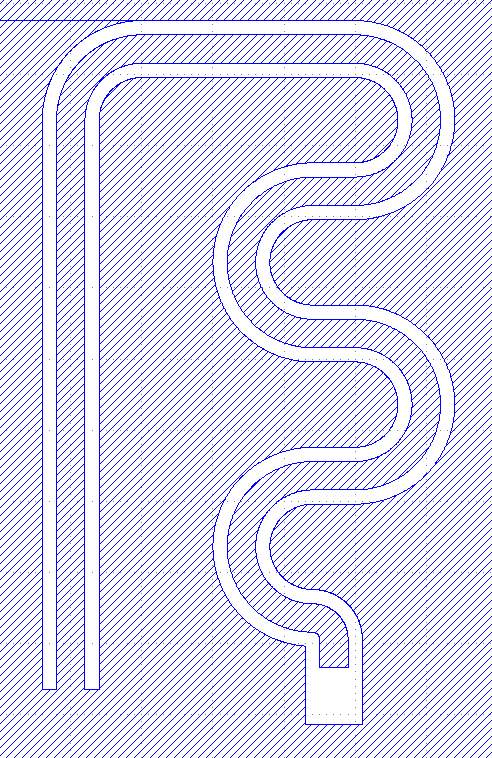

In [534]:
from IPython.display import Image
Image(filename='Z:/DataAnalysis/Notebooks/Design_Tests/Final_Resonator.png')

## Testing the class

We follow the steps from the basic chip code to test the new Resonator class.

In [535]:
layout = db.Layout()

layout.dbu = 0.001 #This means that all numbers will be by reference in nm

if( layout.has_cell( "testScript") ):
    pass
else:
    cell = layout.create_cell( "testScript" )

layer_info_photo = db.LayerInfo(10,0)
layer_photo = layout.layer( layer_info_photo )


In [536]:
class CHIP:
    dx = 7.1e6
    dy = 2.1e6
    L1 = 2.5e6
    gap = 150.e3
    width = 260.e3
    b = 2*gap + width
    origin = db.DPoint( 0,0 )
    box = db.DBox( origin, origin + db.DPoint( dx,dy ) )
    # only 4 connections programmed by now
    connections = [box.p1 + db.DPoint( L1 + b/2,0 ), box.p1 + db.DPoint( dx - (L1+b/2),0 ), box.p2 - db.DPoint( L1 + b/2,0 ),  box.p1 + db.DPoint( L1 + b/2, dy )]

In [537]:
layer_info_photo = db.LayerInfo(10,0)
layer_info_el = db.LayerInfo(1,0)
layer_crosses = db.LayerInfo(2, 0)
layer_text = db.LayerInfo(3, 0)
layer_negative = db.LayerInfo(4, 0)
layer_photo = layout.layer( layer_info_photo )
layer_el = layout.layer( layer_info_el )
layer_cross = layout.layer(layer_crosses)
layer_txt = layout.layer(layer_text)
layer_neg = layout.layer(layer_negative)

In [538]:
N_repetitions = 1
Origin_list = [(0, n*(CHIP.dy))for n in range(N_repetitions)]
origins = Origin_list[0]
origin = DPoint( origins[0], origins[1] )
Origin_V = Vector( origins[0], origins[1] )
cell.shapes( layer_photo ).insert( db.Box( origin, Point( origins[0] + CHIP.dx, origins[1] + CHIP.dy ) ) )

box (0,0;7100000,2100000)

In [540]:
# Contact Length of the Launchers
contact_L = 1e6

# main drive line coplanar
width = 24.1e3
gap = 12.95e3
#p1 = DPoint( 0 , CHIP.dy*2/3 )
#p2 = DPoint( CHIP.dx, CHIP.dy*2/3 )
p1 = origin + DPoint( 0 + contact_L, CHIP.dy*2/3 )
p2 = origin + DPoint( CHIP.dx - contact_L, CHIP.dy*2/3 )
Z0 = CPW( width, gap, p1, p2 )
Z0.place( cell, layer_photo )

In [541]:
# This cell will create another CPW on the edge of the chip, with a higher width and gap.

# left contact pad
width1 = CHIP.width*1.2
gap1 = CHIP.gap*1.2
p3 = origin + DPoint( 0, CHIP.dy*2/3 )
p4 = origin + DPoint( contact_L/2, CHIP.dy*2/3 )
Z1 = CPW( width1, gap1, p3, p4 )
Z1.place( cell, layer_photo )

In [542]:
# This cell draws and adapter between both CPW's, which will bridge them together
adapter1 = CPW2CPW( Z1, Z0, p4, p1 )
adapter1.place( cell, layer_photo )

In [543]:
# Same as above, but only for the right side
# right contact pad
width1 = CHIP.width*1.2
gap1 = CHIP.gap*1.2
p5 = origin + DPoint( CHIP.dx - contact_L/2, CHIP.dy*2/3 )
p6 = origin + DPoint( CHIP.dx, CHIP.dy*2/3 )
Z2 = CPW( width1, gap1, p5, p6 )
Z2.place( cell, layer_photo )

adapter1 = CPW2CPW( Z2, Z0, p5, p2 )
adapter1.place( cell, layer_photo )

In [544]:
# Define resonator parameters

### Coupling lengths
L_coupling = 400e3

### Shorted Length
L_shorted= 400e3

### Open end length
L_open = 200e3

### Length of open end terminations
L_end = 20e3

### Width of the resonator
width_res = 20e3

### Gap between center and ground planes
gap_res = 10e3

### Distance to readout line
toLine = 35e3

## Connections radius
r = 50e3

### Number of turns in resonator
N = 2


### Define the CPW
Z_res = CPW( width_res, gap_res, origin, origin )


# Place bottom array of resonators

### Choose number of resonators
N_bottom = 1
delta = 0.5*CHIP.dx/N_bottom

if N_bottom >1:
    step_bot = (CHIP.dx - 2*contact_L - 2*delta)/(N_bottom-1)
else:
    step_bot = (CHIP.dx - 2*contact_L - 2*delta)

We will use our Resonator class in here

In [545]:
resonators = []
empties = []
for i in range( N_bottom ):
    ### Define the point for the shorted part to begin
    point = origin + DPoint( contact_L + delta + i*step_bot, CHIP.dy*2/3 - ((Z0.width + Z_res.width+50e3)/2 + toLine)  )
    ### Create the resonator and place it in the main layer
    resonator = Resonator( Z_res, point, L_coupling, L_shorted, L_open, L_end, r, N)
    resonator.place( cell, layer_photo )
    resonators.append( resonator )    

In [546]:
layout.write(r'Resonator_Test.gds')